# Recreating the FaceNet Machine Learning algorithm to recognize faces. 

The Facenet model is a keras model which has been made awith pre trained weights. The below implementation is being checked on the Labeled Faces in the Wild Simulated Masked Dataset.

Multiple dataset can be run from the same code. Please uncomment the required lines and comment the required ones when trying to run the model on different datasets.

In [1]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 5.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import mtcnn
import os
import cv2

import numpy as np 
import pandas as pd 
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

#prefix = '/content/gdrive/My Drive/Advanced Machine Learning/Project/lfw_masked/'

#To check with LFW custom masked dataset, uncomment the below line.
prefix = '/content/gdrive/My Drive/Advanced Machine Learning/Project/'

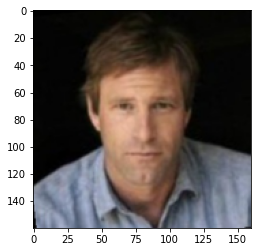

(160, 160, 3)


In [4]:
# Extracting a single face from any given image and resizing it to 160x160

def extractFace(filename, required_size=(160, 160)):
    extracted_image = Image.open(filename)
    extracted_image = extracted_image.convert('RGB')

    extracted_image = extracted_image.resize(required_size)
    face_array = np.asarray(extracted_image)

    return face_array

#Loading a single image and trying to extract the face in the image
#pixels = extractFace(prefix+'lfw_test/Aaron_Peirsol/Aaron_Peirsol_0002.jpg')

#To check with LFW custom masked dataset, uncomment the below line.
pixels = extractFace(prefix+'lfw_funneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')

plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [5]:
#Extract all the faces from images in any given directory

def getFaces(dir):
    faces = list()
    
    for filename in os.listdir(dir):
        path = dir + filename
        face = extractFace(path)
        faces.append(face)
    return faces

def loadDataset(dir):

    X, y = list(), list()
    for subdir in os.listdir(dir):
        path = dir + subdir + '/'
        faces = getFaces(path)
        labels = [subdir for i in range(len(faces))]
        print("Loaded %d images for label: %s" % (len(faces),subdir) ) 
        X.extend(faces)
        y.extend(labels)

    return np.asarray(X), np.asarray(y)


# Loading Training images, that is images to train the facial recognition algorithm 
#trainX, trainy = loadDataset(prefix+'lfw_train/')

trainX, trainy = loadDataset(prefix+'lfw_funneled/')

print(trainX.shape, trainy.shape)

# Loading the Test Data
#testX, testy = loadDataset(prefix+'lfw_test/')

#testX, testy = loadDataset(prefix+'mask_test/')

testX, testy = loadDataset(prefix+'mask_eyewear/')
print(testX.shape, testy.shape)

Streaming output truncated to the last 5000 lines.
Loaded 1 images for label: Dick_Jauron
Loaded 1 images for label: Mark_Heller
Loaded 1 images for label: Nate_Blackwell
Loaded 1 images for label: Terry_McAuliffe
Loaded 1 images for label: Pamela_Anderson
Loaded 1 images for label: Mary_Katherine_Smart
Loaded 1 images for label: Misty_Dawn_Clymer
Loaded 1 images for label: Tina_Conner
Loaded 1 images for label: Ruano_Pascual
Loaded 1 images for label: Hung_Wan-ting
Loaded 1 images for label: Jeong_Se-hyun
Loaded 1 images for label: John_Coomber
Loaded 1 images for label: Lynn_Redgrave
Loaded 1 images for label: Khatol_Mohammad_Zai
Loaded 1 images for label: Roh_Moo-hyun
Loaded 1 images for label: Dot_Helms
Loaded 1 images for label: Joe_Mantello
Loaded 1 images for label: Joe_Pantoliano
Loaded 1 images for label: Sheila_Fraser
Loaded 1 images for label: Isabelle_Huppert
Loaded 1 images for label: Eric_Dubin
Loaded 1 images for label: Guangdong_Ou_Guangyuan
Loaded 1 images for label: M

In [6]:
#As the dataset doesn't fit in the memory, compressing the dataset for any further use
#np.savez_compressed('lfw-masked-dataset.npz', trainX, trainy, testX, testy)

#np.savez_compressed('lfw-custom-masked-dataset.npz', trainX, trainy, testX, testy)
np.savez_compressed('lfw-eyewear-masked-dataset.npz', trainX, trainy, testX, testy)

In [7]:
#From the compressed data loading the train and test values

#data = np.load('lfw-masked-dataset.npz')

#data = np.load('lfw-custom-masked-dataset.npz')
data = np.load('lfw-eyewear-masked-dataset.npz')

trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (13233, 160, 160, 3) (13233,) (5721, 160, 160, 3) (5721,)


In [8]:
#Selecting the weighted FaceNet model

facenet_model = load_model(prefix+'facenet_keras.h5')

In [9]:
''' 
As the FaceNet model uses a Triplet Loss function on the face embeddings to 
recognize any given face,we have to extract the embeddings (features) from the 
image. This can be done using the predict function
of the FaceNet model
'''

def get_embedding(model, face):

    face = face.astype('float32')
    mean, std = face.mean(), face.std()
    face = (face-mean)/std

    # The FaceNet predict function requires the images to be in a 4 dimensional 
    # format.

    formatted_image = np.expand_dims(face, axis=0)
    yhat = model.predict(formatted_image)

    return yhat[0]
    
# Getting the embeddings for all the images for training

emdTrainX = list()
for face in trainX:
    emd = get_embedding(facenet_model, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# Getting the embeddings for all the images for testing
emdTestX = list()
for face in testX:
    emd = get_embedding(facenet_model, face)
    emdTestX.append(emd)

emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

# Saving the embeddings for further use
np.savez_compressed('lfw-masked-embeddings.npz', emdTrainX, trainy, emdTestX, testy)

(13233, 128)
(5721, 128)


In [10]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
encoder_arr = np.append (trainy, ['Ben_Affleck', 'Ben_Curtis', 'Ben_Howland', 'Benazir_Bhutto', 'Benjamin_Netanyahu', 'Bernard_Landry', 'Bernard_Law', 'Bertie_Ahern'])
out_encoder.fit(encoder_arr)
trainy_enc = out_encoder.transform(trainy)
testy_enc = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=13233, test=5721
Accuracy: train=30.741, test=2.098
